# Detect Sentiment from audio

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import keras
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

from keras.utils import np_utils
from keras.utils import to_categorical

from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.layers import Dense, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

import IPython.display as ipd
from scipy import signal
from tqdm import tqdm

input_duration = 3

In [ ]:
train = pd.read_csv('TRAIN.csv')
train

,Filename,Class
0,346.wav,Negative
1,163.wav,Neutral
2,288.wav,Negative
3,279.wav,Negative
4,244.wav,Negative
...,...,...
245,204.wav,Neutral
246,46.wav,Positive
247,318.wav,Negative
248,49.wav,Positive


In [ ]:
files = ['TRAIN/'+ x for x in train['Filename']]

In [ ]:
train['Filename'] = files
train

,Filename,Class
0,TRAIN/346.wav,Negative
1,TRAIN/163.wav,Neutral
2,TRAIN/288.wav,Negative
3,TRAIN/279.wav,Negative
4,TRAIN/244.wav,Negative
...,...,...
245,TRAIN/204.wav,Neutral
246,TRAIN/46.wav,Positive
247,TRAIN/318.wav,Negative
248,TRAIN/49.wav,Positive


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filename  250 non-null    object
 1   Class     250 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB


In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

## Visualize

TRAIN/204.wav


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 0, 'Seconds')

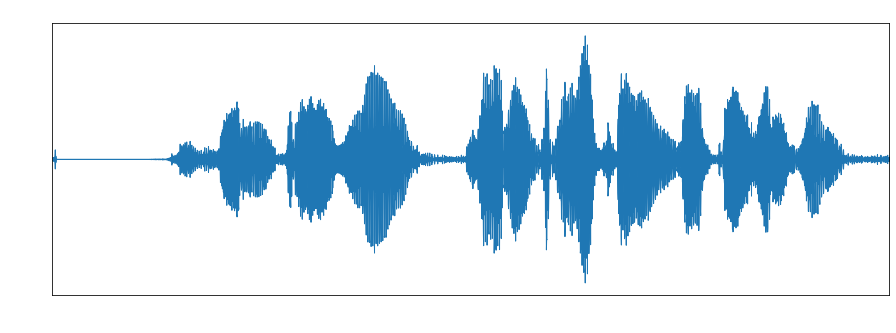

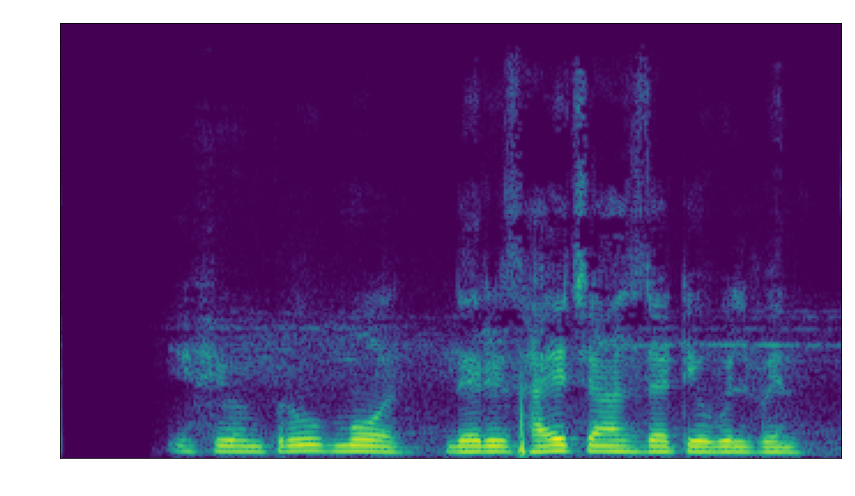

In [ ]:
filename = train['Filename'][245]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples
plt.figure(figsize=(15, 5))
plt.title('Raw wave of ' + filename, color='white')
plt.ylabel('Amplitude', color='white')
plt.xlabel('Time', color='white')
plt.tick_params(colors='white')
librosa.display.waveplot(samples, sr=sample_rate)

freqs, times, spectrogram = log_specgram(samples, sample_rate)
plt.figure(figsize=(14, 8))
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2 = plt.axes()
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
plt.tick_params(colors='white')
ax2.set_title('Spectrogram of ' + filename, color='white')
ax2.set_ylabel('Freqs in Hz', color='white')
ax2.set_xlabel('Seconds', color='white')

In [ ]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-0.00844021, -0.01182155, -0.01387738, ..., -0.00276982,
        -0.00091793,  0.00095176], dtype=float32), array([10752, 72704]))

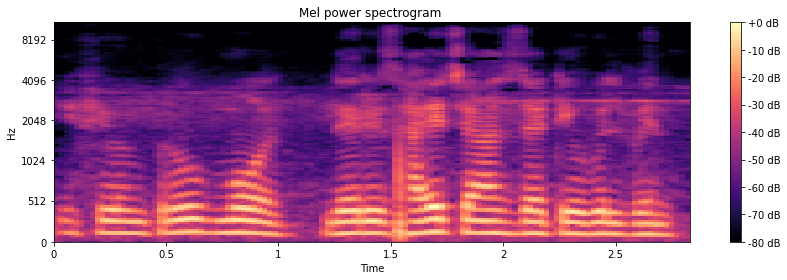

In [ ]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB)
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

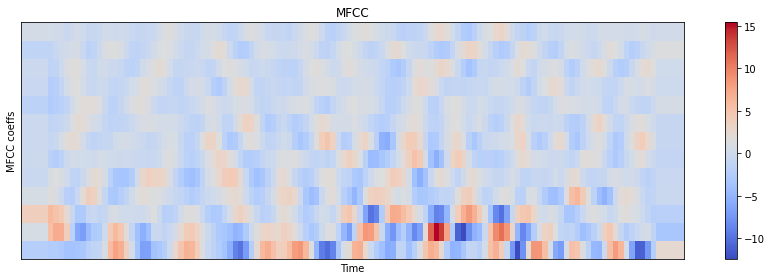

In [ ]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Pad on the first and second deltas
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [ ]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [ ]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [ ]:
count = pd.DataFrame(train.Class.value_counts().reset_index())
count.columns = ['emotions', 'count']

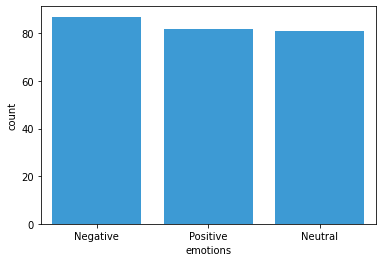

In [ ]:
color_code='#24A0ED'
sns.barplot(x='emotions', y='count', color=color_code, data=count)

In [ ]:
train

,Filename,Class
0,TRAIN/346.wav,Negative
1,TRAIN/163.wav,Neutral
2,TRAIN/288.wav,Negative
3,TRAIN/279.wav,Negative
4,TRAIN/244.wav,Negative
...,...,...
245,TRAIN/204.wav,Neutral
246,TRAIN/46.wav,Positive
247,TRAIN/318.wav,Negative
248,TRAIN/49.wav,Positive


In [ ]:
features = pd.Series()
for i in tqdm(range(len(train))):
    X, sample_rate = librosa.load(train.Filename[i], res_type='kaiser_fast',duration=3, sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    features.loc[i] = feature

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
100%|██████████| 250/250 [00:33<00:00,  7.37it/s]


In [ ]:
features

0      [-44.56341202330582, -44.184866770536374, -43....
1      [-18.385873784085582, -16.849993989827382, -14...
2      [-47.13317676947123, -43.20000611293158, -37.7...
3      [-18.641237255083777, -20.828099435623418, -23...
4      [-46.04466562172441, -44.558792764545174, -46....
                             ...                        
245    [-21.717151600033215, -18.973993285135982, -18...
246    [-41.911386268410766, -41.33915914910916, -41....
247    [-47.04113490541924, -43.41961939127255, -43.8...
248    [-43.4369464248, -44.66659105410739, -44.90464...
249    [21.866125833817797, 23.402780228275414, 23.16...
Length: 250, dtype: object

In [ ]:
features[212].shape, len(features) 

((158,), 250)

In [ ]:
features = pd.concat([pd.DataFrame(features.values.tolist()),train['Filename']], axis=1)
features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,Filename
0,-44.563412,-44.184867,-43.844308,-43.182592,-42.920674,-44.714471,-42.187422,-41.041839,-40.431978,-39.925106,-42.608446,-42.533217,-39.165449,-38.691480,-38.175568,-33.322448,-23.922924,-19.579271,-16.233377,-17.099098,-17.559065,-17.544225,-17.714256,-16.630157,-18.315251,-19.679359,-19.431612,-20.413664,-21.698344,-22.465368,-22.468568,-23.003061,-21.806434,-19.339653,-19.369216,-19.168071,-19.439748,-19.005551,-19.202472,-21.280791,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN/346.wav
1,-18.385874,-16.849994,-14.623190,-10.154396,-8.445595,-5.579896,-4.969350,-3.023102,-2.260265,-1.239677,1.451668,-0.359932,-3.364506,-4.718681,-4.217405,-2.783729,-1.943844,-2.666888,-7.172611,-11.671719,-17.767795,-18.029424,-20.289134,-13.891988,-6.828237,-2.510409,-1.464434,-4.574683,-4.110293,-3.514688,-3.191748,-3.457925,-3.724100,-5.592627,-7.452021,-9.208302,-11.286081,-12.674761,-12.748635,-12.807039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN/163.wav
2,-47.133177,-43.200006,-37.762686,-28.060016,-23.253317,-21.728610,-21.765989,-19.994463,-20.334405,-19.713562,-18.304822,-18.256879,-16.981000,-15.674340,-14.852030,-16.420966,-17.802825,-15.251037,-15.843531,-18.726393,-20.148792,-19.542038,-21.538433,-23.305131,-21.373282,-18.868876,-20.123060,-21.626046,-22.769750,-22.894844,-21.801354,-22.357907,-21.392457,-20.448149,-19.224912,-17.905740,-18.390357,-18.007660,-17.279334,-16.508761,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN/288.wav
3,-18.641237,-20.828099,-23.966028,-23.121903,-22.973465,-21.395796,-20.082872,-18.041319,-17.333568,-18.521541,-17.776709,-18.510584,-20.162066,-21.395256,-19.636227,-19.191106,-22.510410,-25.323331,-26.378982,-27.742360,-27.504204,-25.405800,-20.748456,-18.611351,-19.223107,-20.805163,-20.701095,-18.430778,-16.699245,-16.796557,-18.369711,-19.742267,-22.019355,-20.337430,-19.506609,-21.004678,-18.549125,-17.841400,-19.051040,-18.397749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN/279.wav
4,-46.044666,-44.558793,-46.691841,-45.277189,-36.635479,-29.341196,-25.964886,-23.083122,-21.890096,-22.224281,-21.766250,-19.676925,-18.046196,-17.998061,-17.647992,-16.470041,-15.498452,-13.858371,-13.937545,-14.672666,-15.586124,-15.512557,-15.669805,-17.627052,-19.330287,-18.895488,-20.773779,-21.298105,-17.990843,-16.203934,-16.123090,-17.206885,-16.874457,-15.563441,-15.461896,-15.343992,-15.982402,-16.698671,-15.929227,-15.601940,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN/244.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,-21.717152,-18.973993,-18.246891,-17.785409,-16.257464,-14.987755,-12.912756,-13.615769,-15.053858,-17.543495,-19.494255,-19.924250,-20.483483,-20.818372,-19.177417,-14.378186,-13.761088,-12.790615,-11.607050,-12.130851,-12.593934,-11.805730,-12.887580,-13.126731,-12.568370,-11.859299,-11.193574,-11.098001,-12.261120,-12.543215,-11.63

In [ ]:
features.isnull().sum().sum()

18826

In [ ]:
features_cleaned = features.fillna(0)
features_cleaned

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,Filename
0,-44.563412,-44.184867,-43.844308,-43.182592,-42.920674,-44.714471,-42.187422,-41.041839,-40.431978,-39.925106,-42.608446,-42.533217,-39.165449,-38.691480,-38.175568,-33.322448,-23.922924,-19.579271,-16.233377,-17.099098,-17.559065,-17.544225,-17.714256,-16.630157,-18.315251,-19.679359,-19.431612,-20.413664,-21.698344,-22.465368,-22.468568,-23.003061,-21.806434,-19.339653,-19.369216,-19.168071,-19.439748,-19.005551,-19.202472,-21.280791,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TRAIN/346.wav
1,-18.385874,-16.849994,-14.623190,-10.154396,-8.445595,-5.579896,-4.969350,-3.023102,-2.260265,-1.239677,1.451668,-0.359932,-3.364506,-4.718681,-4.217405,-2.783729,-1.943844,-2.666888,-7.172611,-11.671719,-17.767795,-18.029424,-20.289134,-13.891988,-6.828237,-2.510409,-1.464434,-4.574683,-4.110293,-3.514688,-3.191748,-3.457925,-3.724100,-5.592627,-7.452021,-9.208302,-11.286081,-12.674761,-12.748635,-12.807039,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TRAIN/163.wav
2,-47.133177,-43.200006,-37.762686,-28.060016,-23.253317,-21.728610,-21.765989,-19.994463,-20.334405,-19.713562,-18.304822,-18.256879,-16.981000,-15.674340,-14.852030,-16.420966,-17.802825,-15.251037,-15.843531,-18.726393,-20.148792,-19.542038,-21.538433,-23.305131,-21.373282,-18.868876,-20.123060,-21.626046,-22.769750,-22.894844,-21.801354,-22.357907,-21.392457,-20.448149,-19.224912,-17.905740,-18.390357,-18.007660,-17.279334,-16.508761,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TRAIN/288.wav
3,-18.641237,-20.828099,-23.966028,-23.121903,-22.973465,-21.395796,-20.082872,-18.041319,-17.333568,-18.521541,-17.776709,-18.510584,-20.162066,-21.395256,-19.636227,-19.191106,-22.510410,-25.323331,-26.378982,-27.742360,-27.504204,-25.405800,-20.748456,-18.611351,-19.223107,-20.805163,-20.701095,-18.430778,-16.699245,-16.796557,-18.369711,-19.742267,-22.019355,-20.337430,-19.506609,-21.004678,-18.549125,-17.841400,-19.051040,-18.397749,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TRAIN/279.wav
4,-46.044666,-44.558793,-46.691841,-45.277189,-36.635479,-29.341196,-25.964886,-23.083122,-21.890096,-22.224281,-21.766250,-19.676925,-18.046196,-17.998061,-17.647992,-16.470041,-15.498452,-13.858371,-13.937545,-14.672666,-15.586124,-15.512557,-15.669805,-17.627052,-19.330287,-18.895488,-20.773779,-21.298105,-17.990843,-16.203934,-16.123090,-17.206885,-16.874457,-15.563441,-15.461896,-15.343992,-15.982402,-16.698671,-15.929227,-15.601940,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [ ]:
labelled_df = pd.concat([train, features_cleaned.drop('Filename', axis=1)], axis=1)

In [ ]:
labelled_df

,Filename,Class,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,TRAIN/346.wav,Negative,-44.563412,-44.184867,-43.844308,-43.182592,-42.920674,-44.714471,-42.187422,-41.041839,-40.431978,-39.925106,-42.608446,-42.533217,-39.165449,-38.691480,-38.175568,-33.322448,-23.922924,-19.579271,-16.233377,-17.099098,-17.559065,-17.544225,-17.714256,-16.630157,-18.315251,-19.679359,-19.431612,-20.413664,-21.698344,-22.465368,-22.468568,-23.003061,-21.806434,-19.339653,-19.369216,-19.168071,-19.439748,-19.005551,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TRAIN/163.wav,Neutral,-18.385874,-16.849994,-14.623190,-10.154396,-8.445595,-5.579896,-4.969350,-3.023102,-2.260265,-1.239677,1.451668,-0.359932,-3.364506,-4.718681,-4.217405,-2.783729,-1.943844,-2.666888,-7.172611,-11.671719,-17.767795,-18.029424,-20.289134,-13.891988,-6.828237,-2.510409,-1.464434,-4.574683,-4.110293,-3.514688,-3.191748,-3.457925,-3.724100,-5.592627,-7.452021,-9.208302,-11.286081,-12.674761,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TRAIN/288.wav,Negative,-47.133177,-43.200006,-37.762686,-28.060016,-23.253317,-21.728610,-21.765989,-19.994463,-20.334405,-19.713562,-18.304822,-18.256879,-16.981000,-15.674340,-14.852030,-16.420966,-17.802825,-15.251037,-15.843531,-18.726393,-20.148792,-19.542038,-21.538433,-23.305131,-21.373282,-18.868876,-20.123060,-21.626046,-22.769750,-22.894844,-21.801354,-22.357907,-21.392457,-20.448149,-19.224912,-17.905740,-18.390357,-18.007660,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TRAIN/279.wav,Negative,-18.641237,-20.828099,-23.966028,-23.121903,-22.973465,-21.395796,-20.082872,-18.041319,-17.333568,-18.521541,-17.776709,-18.510584,-20.162066,-21.395256,-19.636227,-19.191106,-22.510410,-25.323331,-26.378982,-27.742360,-27.504204,-25.405800,-20.748456,-18.611351,-19.223107,-20.805163,-20.701095,-18.430778,-16.699245,-16.796557,-18.369711,-19.742267,-22.019355,-20.337430,-19.506609,-21.004678,-18.549125,-17.841400,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TRAIN/244.wav,Negative,-46.044666,-44.558793,-46.691841,-45.277189,-36.635479,-29.341196,-25.964886,-23.083122,-21.890096,-22.224281,-21.766250,-19.676925,-18.046196,-17.998061,-17.647992,-16.470041,-15.498452,-13.858371,-13.937545,-14.672666,-15.586124,-15.512557,-15.669805,-17.627052,-19.330287,-18.895488,-20.773779,-21.298105,-17.990843,-16.203934,-16.123090,-17.206885,-16.874457,-15.563441,-15.461896,-15.343992,-15.982402,-16.698671,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

## Augmentation

In [ ]:
def plot_time_series(data):
  # Plot the Audio Frequency
  fig = plt.figure(figsize=(14, 8))
  plt.title('Raw wave ', color='white')
  plt.ylabel('Amplitude', color='white')
  plt.plot(np.linspace(0, 1, len(data)), data)
  plt.tick_params(colors='white')
  plt.show()


def noise(data):
  # Adding White Noise.
  noise_amp = 0.005*np.random.uniform()*np.amax(data)
  data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
  return data
    
def shift(data):
  # Random Shifting.
  s_range = int(np.random.uniform(low=-5, high = 5)*500)
  return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
  # Streching the Sound.
  data = librosa.effects.time_stretch(data, rate)
  return data
    
def pitch(data, sample_rate):
  # Pitch Tuning.
  bins_per_octave = 12
  pitch_pm = 2
  pitch_change =  pitch_pm * 2*(np.random.uniform())   
  data = librosa.effects.pitch_shift(data.astype('float64'), 
                                    sample_rate, n_steps=pitch_change, 
                                    bins_per_octave=bins_per_octave)
  return data
    
def dyn_change(data):
  # Random Value Change.
  dyn_change = np.random.uniform(low=1.5,high=3)
  return (data * dyn_change)
    
def speedNpitch(data):
  # peed and Pitch Tuning.
  # you can change low and high here
  length_change = np.random.uniform(low=0.8, high = 1)
  speed_fac = 1.0  / length_change
  tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
  minlen = min(data.shape[0], tmp.shape[0])
  data *= 0
  data[0:minlen] = tmp[0:minlen]
  return data

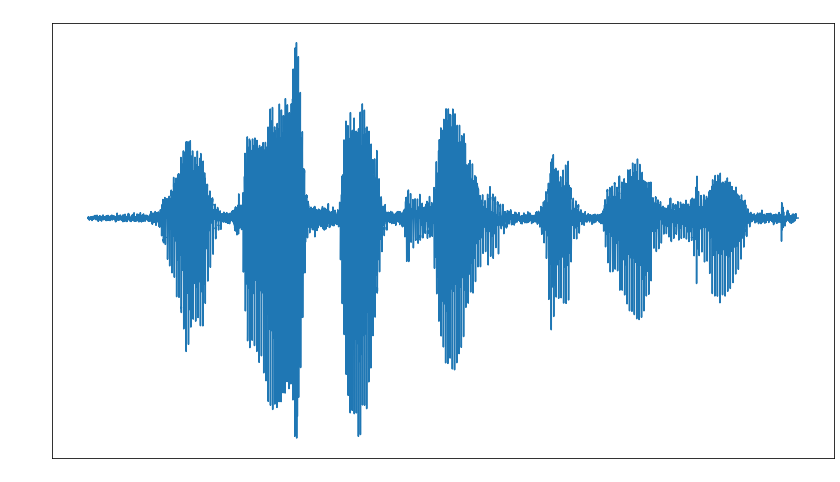

In [ ]:
X, sample_rate = librosa.load(labelled_df.Filename[160], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

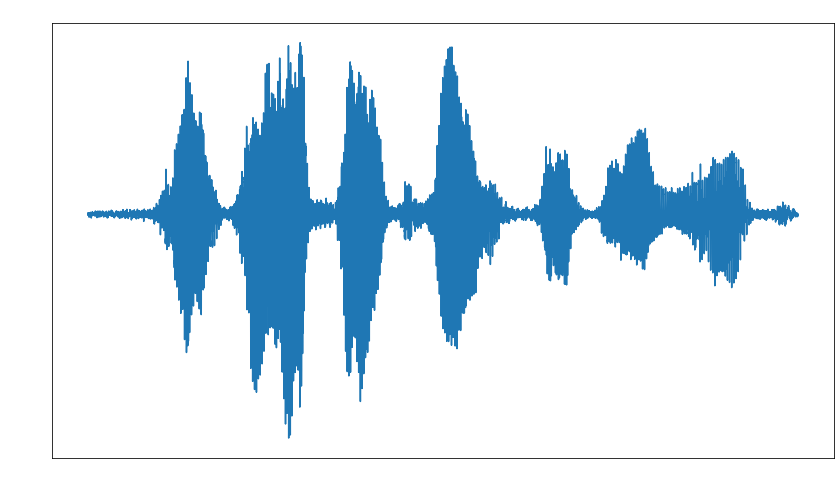

In [ ]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [ ]:
# Augmentation of Noise
syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(labelled_df))):
    X, sample_rate = librosa.load(labelled_df.Filename[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if labelled_df.Class[i]:
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, labelled_df.Class[i]]

100%|██████████| 250/250 [00:36<00:00,  6.81it/s]


In [ ]:
# Augmentation of Pitch

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(labelled_df))):
    X, sample_rate = librosa.load(labelled_df.Filename[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if labelled_df.Class[i]:
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, labelled_df.Class[i]]


100%|██████████| 250/250 [01:01<00:00,  4.06it/s]


In [ ]:
len(syn_data1), len(syn_data2) 

(250, 250)

In [ ]:
syn_data1

,feature,label
0,"[-43.95188544642271, -42.538590642103024, -42....",Negative
1,"[-16.37752334297511, -15.329076271338057, -13....",Neutral
2,"[-46.771079680252996, -42.886733645666204, -36...",Negative
3,"[-18.148035313142806, -20.410679787812878, -23...",Negative
4,"[-41.01493811046084, -40.53806274702906, -41.7...",Negative
...,...,...
245,"[-21.47685293988554, -18.613187716476805, -17....",Neutral
246,"[-40.9737602181698, -40.75655934123968, -41.32...",Positive
247,"[-42.66559139599284, -40.865905440568525, -40....",Negative
248,"[-39.86544109954619, -41.34826179866719, -42.5...",Positive


In [ ]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [ ]:
df1 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels1 = syn_data1.label
syndf1 = pd.concat([df1,labels1], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

250

In [ ]:
syndf1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-43.951885,-42.538591,-42.169787,-42.872484,-41.376935,-43.227207,-40.917888,-39.998853,-40.194669,-39.359317,-42.062749,-41.905189,-38.506171,-38.343736,-38.024942,-32.401943,-23.289451,-18.936487,-15.580040,-16.557699,-17.075107,-17.050425,-17.260132,-16.306710,-17.980594,-19.294328,-19.106412,-19.865404,-21.116791,-21.895223,-21.996785,-22.634934,-21.352809,-18.828501,-18.778409,-18.574629,-18.923135,-18.402618,-18.629005,-20.756694,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
1,-16.377523,-15.329076,-13.206586,-8.487288,-6.771544,-4.092273,-3.719720,-1.908869,-1.173034,-0.382393,2.287718,0.580244,-2.486707,-3.786084,-3.201610,-1.683233,-0.632128,-1.146367,-5.161667,-9.032906,-15.858955,-16.901379,-18.656179,-12.756531,-5.733696,-1.369251,-0.441739,-3.453796,-3.074583,-2.476874,-2.125146,-2.254170,-2.491472,-4.461420,-6.133260,-7.345918,-8.941236,-10.525088,-10.571714,-10.848555,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
2,-46.771080,-42.886734,-36.294958,-26.996257,-22.577388,-21.043729,-21.259974,-19.604592,-19.958749,-19.393942,-17.952162,-17.765413,-16.635712,-15.267482,-14.592438,-16.121992,-17.511314,-15.020375,-15.635851,-18.503248,-19.942838,-19.259486,-21.215068,-23.195565,-21.107202,-18.642647,-19.910434,-21.493796,-22.436760,-22.489433,-21.441378,-22.091739,-21.171963,-20.299651,-18.865673,-17.795806,-18.273477,-17.810518,-17.024593,-16.193550,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
3,-18.148035,-20.410680,-23.638958,-22.745944,-22.537572,-20.929095,-19.770264,-17.865441,-17.141240,-18.342240,-17.611872,-18.349574,-19.932786,-21.140313,-19.419161,-18.945694,-22.274009,-25.076924,-26.117930,-27.385719,-27.201529,-25.117208,-20.517750,-18.360346,-18.923955,-20.466145,-20.511748,-18.229472,-16.448009,-16.594513,-18.195992,-19.570150,-21.780562,-20.051058,-19.238253,-20.616409,-18.239522,-17.583559,-18.822435,-18.230169,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
4,-41.014938,-40.538063,-41.748056,-42.147295,-33.056297,-25.949101,-23.363715,-21.087462,-20.266927,-20.714788,-20.329935,-18.130195,-16.412019,-16.164210,-16.200259,-15.313946,-14.382627,-12.941158,-13.136810,-13.875873,-14.741488,-14.715732,-14.469332,-16.064303,-17.867664,-17.478757,-19.566733,-20.032676,-16.786927,-15.114822,-15.035084,-16.128535,-15.600359,-14.304818,-14.409750,-14.202854,-14.437335,-15.440175,-14.884733,-14.704985,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [ ]:
df2 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels2 = syn_data2.label
syndf2 = pd.concat([df2,labels2], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

250

In [ ]:
syndf2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-45.828807,-45.833317,-45.670251,-45.218561,-46.737801,-45.353970,-44.745726,-42.715866,-42.776597,-44.348206,-45.658084,-45.014935,-41.750491,-40.646131,-37.579667,-30.638413,-25.414768,-21.734031,-19.939079,-19.754717,-20.315359,-20.804907,-21.347923,-21.837716,-21.018303,-23.569589,-23.232760,-24.367099,-25.152853,-26.699293,-27.199394,-27.022147,-26.355442,-26.427338,-23.830723,-24.908307,-22.969748,-23.331437,-25.277023,-25.055382,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
1,-17.989774,-16.638907,-15.039781,-11.929241,-9.086828,-7.773060,-7.237539,-6.774186,-4.711905,-3.989352,-3.369027,-4.541804,-6.115980,-6.129978,-5.155246,-5.072170,-4.941596,-8.620463,-10.655679,-12.996303,-16.746022,-19.765409,-17.671602,-10.921729,-6.827291,-4.971004,-5.441426,-4.485155,-6.593464,-8.180612,-6.670269,-6.442419,-6.841094,-7.590796,-9.011618,-11.786576,-14.232607,-15.458371,-15.491167,-15.467951,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
2,-47.248493,-40.620388,-39.585100,-32.763866,-26.394618,-25.280614,-24.807472,-23.956001,-23.670745,-24.298953,-23.398263,-22.348031,-21.996442,-21.324089,-18.730632,-18.302144,-21.283306,-20.646098,-20.136638,-22.041446,-23.681233,-24.275839,-25.199050,-25.664026,-24.602101,-23.947643,-24.536948,-26.181381,-28.512334,-26.906363,-25.485072,-25.167509,-24.832377,-23.234146,-24.390516,-23.812006,-24.250616,-23.562679,-23.907015,-22.807141,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
3,-19.010587,-21.714425,-26.909642,-26.468228,-25.683708,-24.013073,-24.625121,-22.488121,-20.457249,-19.905310,-21.093504,-21.128971,-22.407123,-22.956982,-22.543279,-23.563631,-26.067203,-28.369182,-29.890321,-30.907063,-30.803638,-26.719495,-22.628149,-22.021518,-21.009535,-20.855510,-21.340902,-20.252718,-20.125782,-21.532406,-22.859567,-23.558972,-24.651117,-23.481403,-22.748552,-22.348720,-21.138160,-20.750806,-22.251604,-22.820323,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
4,-46.500307,-45.224078,-46.162713,-42.940465,-39.931315,-36.427070,-32.469634,-29.454746,-28.920077,-26.893942,-26.566748,-24.857603,-23.266579,-22.537593,-22.565179,-21.112830,-20.202380,-19.956556,-20.836351,-19.782589,-20.641889,-21.565637,-21.318983,-21.672762,-23.808799,-24.455261,-23.121257,-23.656103,-20.801618,-19.238520,-20.835261,-21.726785,-23.204315,-23.630459,-22.490068,-21.898614,-21.955953,-20.846898,-20.487639,-19.513338,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [ ]:
# Combining the Augmented data with original
combined_df = pd.concat([labelled_df.rename(columns={'Class': 'label'}), syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0).drop('Filename', axis=1)
combined_df

,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,Negative,-44.563412,-44.184867,-43.844308,-43.182592,-42.920674,-44.714471,-42.187422,-41.041839,-40.431978,-39.925106,-42.608446,-42.533217,-39.165449,-38.691480,-38.175568,-33.322448,-23.922924,-19.579271,-16.233377,-17.099098,-17.559065,-17.544225,-17.714256,-16.630157,-18.315251,-19.679359,-19.431612,-20.413664,-21.698344,-22.465368,-22.468568,-23.003061,-21.806434,-19.339653,-19.369216,-19.168071,-19.439748,-19.005551,-19.202472,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Neutral,-18.385874,-16.849994,-14.623190,-10.154396,-8.445595,-5.579896,-4.969350,-3.023102,-2.260265,-1.239677,1.451668,-0.359932,-3.364506,-4.718681,-4.217405,-2.783729,-1.943844,-2.666888,-7.172611,-11.671719,-17.767795,-18.029424,-20.289134,-13.891988,-6.828237,-2.510409,-1.464434,-4.574683,-4.110293,-3.514688,-3.191748,-3.457925,-3.724100,-5.592627,-7.452021,-9.208302,-11.286081,-12.674761,-12.748635,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Negative,-47.133177,-43.200006,-37.762686,-28.060016,-23.253317,-21.728610,-21.765989,-19.994463,-20.334405,-19.713562,-18.304822,-18.256879,-16.981000,-15.674340,-14.852030,-16.420966,-17.802825,-15.251037,-15.843531,-18.726393,-20.148792,-19.542038,-21.538433,-23.305131,-21.373282,-18.868876,-20.123060,-21.626046,-22.769750,-22.894844,-21.801354,-22.357907,-21.392457,-20.448149,-19.224912,-17.905740,-18.390357,-18.007660,-17.279334,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Negative,-18.641237,-20.828099,-23.966028,-23.121903,-22.973465,-21.395796,-20.082872,-18.041319,-17.333568,-18.521541,-17.776709,-18.510584,-20.162066,-21.395256,-19.636227,-19.191106,-22.510410,-25.323331,-26.378982,-27.742360,-27.504204,-25.405800,-20.748456,-18.611351,-19.223107,-20.805163,-20.701095,-18.430778,-16.699245,-16.796557,-18.369711,-19.742267,-22.019355,-20.337430,-19.506609,-21.004678,-18.549125,-17.841400,-19.051040,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Negative,-46.044666,-44.558793,-46.691841,-45.277189,-36.635479,-29.341196,-25.964886,-23.083122,-21.890096,-22.224281,-21.766250,-19.676925,-18.046196,-17.998061,-17.647992,-16.470041,-15.498452,-13.858371,-13.937545,-14.672666,-15.586124,-15.512557,-15.669805,-17.627052,-19.330287,-18.895488,-20.773779,-21.298105,-17.990843,-16.203934,-16.123090,-17.206885,-16.874457,-15.563441,-15.461896,-15.343992,-15.982402,-16.698671,-15.929227,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [ ]:
#  Stratified Shuffle Split
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, valid_index in xxx.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

In [ ]:
y_train.value_counts()

Negative    209
Positive    197
Neutral     194
Name: label, dtype: int64

In [ ]:
y_valid.value_counts()

Negative    52
Positive    49
Neutral     49
Name: label, dtype: int64

In [ ]:
X_train.isna().sum().sum()

0

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_valid = np_utils.to_categorical(lb.fit_transform(y_valid))

In [ ]:
y_train.shape

(600, 3)

In [ ]:
X_train.shape

(600, 259)

In [ ]:
y_train.shape

(600, 3)

# Model

In [ ]:
x_traincnn = np.expand_dims(X_train.astype('float32'), axis=2)
x_validcnn = np.expand_dims(X_valid.astype('float32'), axis=2)

In [ ]:
x_traincnn.shape, x_validcnn.shape

((600, 259, 1), (150, 259, 1))

In [ ]:
# Keras util functions
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return float(0)

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [ ]:
# Model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(32))

model.add(Dense(3))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0002, momentum=0.0, decay=0.0001, nesterov=False)

In [ ]:
# Plotting Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 259, 256)          2304      
_________________________________________________________________
activation_7 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_3 (Batch (None, 259, 256)          1024      
_________________________________________________________________
activation_8 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 32, 256)          

In [ ]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [ ]:
x_validcnn.dtype, y_valid.dtype

(dtype('float32'), dtype('float32'))

In [ ]:
# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)

mcp_save = ModelCheckpoint('model/aug_noiseNshift.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=350,
                     validation_data=(x_validcnn, y_valid), callbacks=[mcp_save, lr_reduce])

Epoch 1/350
38/38 [==============================] - 2s 23ms/step - loss: 1.2404 - accuracy: 0.3547 - fscore: 0.2833 - val_loss: 1.0718 - val_accuracy: 0.3133 - val_fscore: 0.1593
Epoch 2/350
38/38 [==============================] - 1s 15ms/step - loss: 1.0127 - accuracy: 0.4840 - fscore: 0.3659 - val_loss: 1.0348 - val_accuracy: 0.3333 - val_fscore: 0.1248
Epoch 3/350
38/38 [==============================] - 1s 15ms/step - loss: 0.9251 - accuracy: 0.5617 - fscore: 0.4532 - val_loss: 0.9883 - val_accuracy: 0.4933 - val_fscore: 0.1460
Epoch 4/350
38/38 [==============================] - 1s 15ms/step - loss: 0.9041 - accuracy: 0.5606 - fscore: 0.4456 - val_loss: 0.9584 - val_accuracy: 0.5667 - val_fscore: 0.1835
Epoch 5/350
38/38 [==============================] - 1s 15ms/step - loss: 0.8533 - accuracy: 0.6107 - fscore: 0.5482 - val_loss: 0.9160 - val_accuracy: 0.6400 - val_fscore: 0.2033
Epoch 6/350
38/38 [==============================] - 1s 15ms/step - loss: 0.8422 - accuracy: 0.6147 

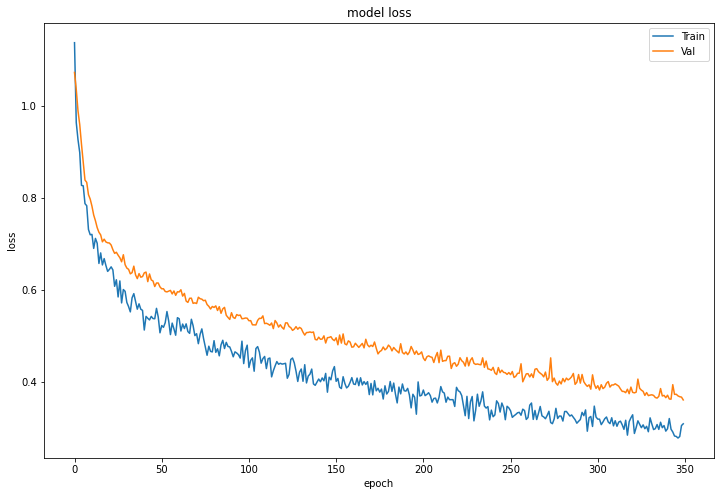

In [ ]:
# Plotting the Train Valid Loss Graph

plt.figure(figsize=(12, 8))
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
# Saving the model.json
import json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/aug_noiseNshift.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_validcnn, y_valid, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 87.33%


In [ ]:
y_valid_pred = loaded_model.predict(x_validcnn, 
                          batch_size=16, 
                          verbose=1)

10/10 [==============================] - 0s 4ms/step


In [ ]:
from sklearn.metrics import accuracy_score
y_true = np.argmax(y_valid, axis=1)
y_pred = np.argmax(y_valid_pred, axis=1)
accuracy_score(y_true, y_pred)*100

87.33333333333333

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

87.26462694578636

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[46,  1,  5],
       [ 2, 47,  0],
       [ 8,  3, 38]])

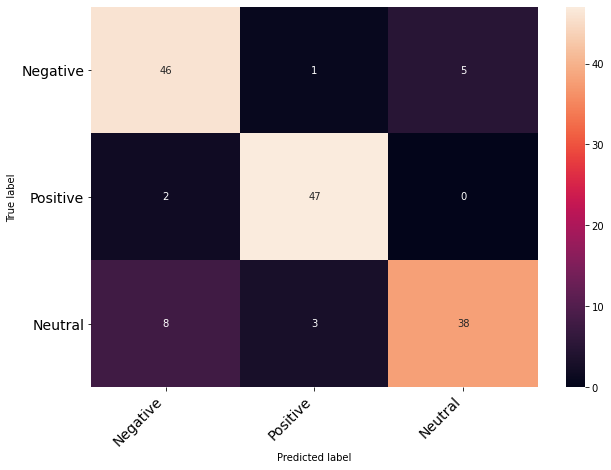

In [ ]:
class_names = ['Negative', 'Positive', 'Neutral']

print_confusion_matrix(c, class_names)

# Prediction on test data

In [ ]:
test_list = os.listdir('TEST/')
print (test_list)

['157.wav', '26.wav', '75.wav', '185.wav', '136.wav', '95.wav', '41.wav', '124.wav', '25.wav', '296.wav', '59.wav', '4.wav', '132.wav', '290.wav', '267.wav', '141.wav', '33.wav', '219.wav', '56.wav', '65.wav', '326.wav', '131.wav', '125.wav', '257.wav', '152.wav', '135.wav', '81.wav', '358.wav', '45.wav', '213.wav', '88.wav', '128.wav', '335.wav', '212.wav', '268.wav', '23.wav', '285.wav', '51.wav', '294.wav', '138.wav', '325.wav', '194.wav', '195.wav', '123.wav', '119.wav', '348.wav', '72.wav', '13.wav', '146.wav', '98.wav', '176.wav', '311.wav', '158.wav', '173.wav', '175.wav', '7.wav', '94.wav', '199.wav', '178.wav', '356.wav', '113.wav', '206.wav', '359.wav', '86.wav', '142.wav', '15.wav', '8.wav', '341.wav', '304.wav', '61.wav', '298.wav', '66.wav', '345.wav', '249.wav', '87.wav', '309.wav', '35.wav', '259.wav', '130.wav', '34.wav', '143.wav', '42.wav', '225.wav', '19.wav', '115.wav', '57.wav', '315.wav', '260.wav', '238.wav', '202.wav', '300.wav', '338.wav', '229.wav', '92.wav', 

In [ ]:
test = ['TEST/'+ x for x in test_list]

In [ ]:
test_df = pd.DataFrame(test, columns=['path'])

In [ ]:
test_df

,path
0,TEST/157.wav
1,TEST/26.wav
2,TEST/75.wav
3,TEST/185.wav
4,TEST/136.wav
...,...
105,TEST/182.wav
106,TEST/134.wav
107,TEST/322.wav
108,TEST/165.wav


In [ ]:
len(test_df)

110

In [ ]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(test_df))):
    X, sample_rate = librosa.load(test_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 110/110 [00:26<00:00,  4.15it/s]


In [ ]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

7/7 [==============================] - 0s 5ms/step


In [ ]:
preds

array([[0.01507688, 0.96809644, 0.01682669],
       [0.11680062, 0.310937  , 0.5722624 ],
       [0.2664666 , 0.10416397, 0.6293694 ],
       [0.28963557, 0.6534988 , 0.05686552],
       [0.00646109, 0.98475677, 0.00878214],
       [0.50278693, 0.14150052, 0.35571256],
       [0.18834591, 0.22602564, 0.58562845],
       [0.00460213, 0.9897059 , 0.00569188],
       [0.32679895, 0.03766911, 0.6355319 ],
       [0.41228402, 0.15619488, 0.43152112],
       [0.25835723, 0.13695559, 0.60468715],
       [0.56353635, 0.01773322, 0.41873038],
       [0.02228533, 0.9588109 , 0.01890371],
       [0.17464687, 0.1934049 , 0.6319482 ],
       [0.584626  , 0.08227561, 0.33309838],
       [0.00453655, 0.9880465 , 0.00741691],
       [0.11294155, 0.01577318, 0.87128526],
       [0.00637021, 0.9872168 , 0.00641297],
       [0.14838165, 0.25803685, 0.5935815 ],
       [0.10077105, 0.34011316, 0.55911577],
       [0.1385656 , 0.3761161 , 0.48531833],
       [0.56234914, 0.17165066, 0.26600024],
       [0.

In [ ]:
prediction = preds.argmax(axis=1)

In [ ]:
prediction

array([1, 2, 2, 1, 1, 0, 2, 1, 2, 2, 2, 0, 1, 2, 0, 1, 2, 1, 2, 2, 2, 0,
       1, 0, 0, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 0, 2, 0, 1, 0, 0, 1, 1,
       2, 0, 2, 0, 1, 2, 1, 0, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 0,
       2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1, 2, 2, 2, 0, 0,
       1, 1, 0, 0, 1, 2, 2, 0, 0, 1, 0, 2, 2, 1, 1, 0, 2, 0, 1, 0, 1, 2])

In [ ]:
abc = prediction.astype(int).flatten()

In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:
preddf = pd.DataFrame({'Filename': test_list, 'Class': predictions})
preddf[:10]

,Filename,Class
0,157.wav,Neutral
1,26.wav,Positive
2,75.wav,Positive
3,185.wav,Neutral
4,136.wav,Neutral
5,95.wav,Negative
6,41.wav,Positive
7,124.wav,Neutral
8,25.wav,Positive
9,296.wav,Positive


In [ ]:
preddf.groupby('Class').count()

,Filename
Class,
Negative,35
Neutral,36
Positive,39


In [ ]:
preddf.iloc[0][0].strip('.wav')

'157'

In [ ]:
preddf['Filename'][0].strip('.wav')

'157'